<a href="https://colab.research.google.com/github/Al-RaoushBasel/Fake-News-Detector/blob/main/FakeNewsDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure permissions
!kaggle competitions download -c fake-news
import zipfile

with zipfile.ZipFile("fake-news.zip", "r") as zip_ref:
    zip_ref.extractall("data")
import os
print(os.listdir("data"))
import pandas as pd

df = pd.read_csv("data/train.csv")
print(df.head())  # Show first 5 rows
print(df.info())  # Show column details

Saving kaggle.json to kaggle.json
fake-news.zip: Skipping, found more recently modified local copy (use --force to force download)
['submit.csv', 'test.csv', 'train.csv']
   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been s

Since we only have a few missing values, we should:
1️⃣ Drop rows where text is missing (because text is the most important part).
2️⃣ Fill missing title with part of the text.
3️⃣ Replace missing author with "Anonymous".

In [2]:
# Drop rows where the text column is missing
df = df.dropna(subset=['text'])

# Replace missing titles with the first 50 characters of the text
df.loc[df['title'].isna(), 'title'] = df['text'].str[:50]

# Replace missing author names
df.loc[df['author'].isna(), 'author'] = "Anonymous"
df.isnull().sum()

,0
id,0
title,0
author,0
text,0
label,0


# Text Preprocessing:

 Convert all text to lowercase for consistency.

Removing Punctuation & Special Characters.

Tokenization – Splitting text into words (tokens).



In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import PorterStemmer


nltk.download('stopwords')
nltk.download('punkt')


stop_words = set(stopwords.words('english'))


stemmer = PorterStemmer()

def preprocess_text(text):
    if isinstance(text, float):
        return ""

    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = wordpunct_tokenize(text)
    words = [stemmer.stem(word) for word in words if word not in stop_words]  # Remove stopwords + stem

    return ' '.join(words)

df['clean_text'] = df['text'].map(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
print(df[['text', 'clean_text']].head())

                                                text  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1  Ever get the feeling your life circles the rou...   
2  Why the Truth Might Get You Fired October 29, ...   
3  Videos 15 Civilians Killed In Single US Airstr...   
4  Print \nAn Iranian woman has been sentenced to...   

                                          clean_text  
0  hous dem aid didnt even see comey letter jason...  
1  ever get feel life circl roundabout rather hea...  
2  truth might get fire octob 29 2016 tension int...  
3  video 15 civilian kill singl us airstrik ident...  
4  print iranian woman sentenc six year prison ir...  


# Exploratory Data Analysis (EDA)

Helps you understand patterns in the data.
Identifies imbalanced labels (e.g., more fake news than real news?).

What We Can Do in EDA:
Check Label Distribution – Are fake and real news balanced?

Text Length Analysis – Do fake and real news articles have different word counts?

Most Common Words – What are the most frequent words in fake vs real news?

Word Clouds – A visual way to see key words in both categories.

# 1️⃣ Check Label Distribution

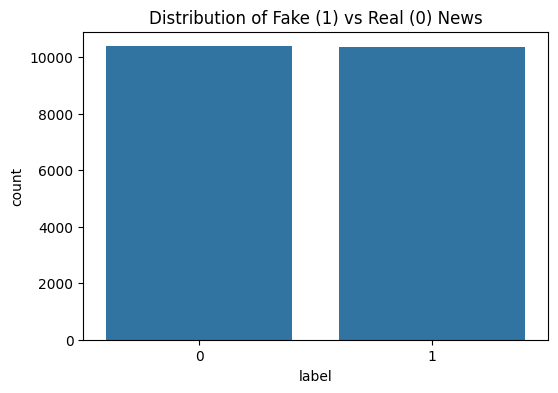

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count plot
plt.figure(figsize=(6,4))
sns.countplot(x=df['label'])
plt.title("Distribution of Fake (1) vs Real (0) News")
plt.show()

# 2️⃣ Text Length Analysis

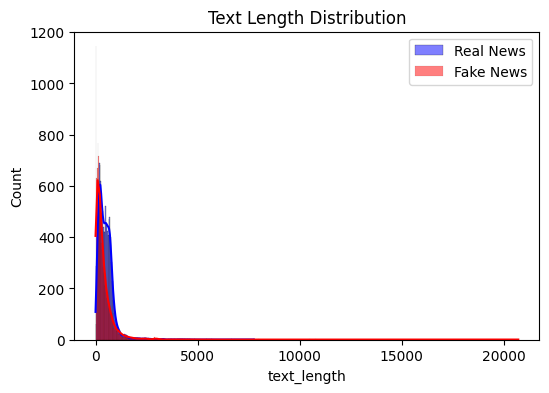

In [6]:
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
sns.histplot(df[df['label'] == 0]['text_length'], label='Real News', kde=True, color='blue')
sns.histplot(df[df['label'] == 1]['text_length'], label='Fake News', kde=True, color='red')
plt.legend()
plt.title("Text Length Distribution")
plt.show()

# 3️⃣ Most Common Words in Fake vs. Real News

In [7]:
from collections import Counter

# Function to get most common words
def get_most_common_words(texts, n=20):
    words = " ".join(texts).split()
    return Counter(words).most_common(n)

# Top words for fake news
fake_words = get_most_common_words(df[df['label'] == 1]['clean_text'])
real_words = get_most_common_words(df[df['label'] == 0]['clean_text'])

print("Most Common Words in Fake News:", fake_words)
print("Most Common Words in Real News:", real_words)

Most Common Words in Fake News: [('us', 20179), ('clinton', 19820), ('trump', 19724), ('peopl', 16840), ('one', 16310), ('state', 15945), ('would', 14450), ('hillari', 12600), ('like', 12596), ('time', 12241), ('said', 11840), ('elect', 10911), ('year', 10404), ('new', 10326), ('american', 10028), ('also', 9903), ('use', 9555), ('go', 9353), ('presid', 9206), ('even', 9093)]
Most Common Words in Real News: [('mr', 69266), ('said', 68171), ('trump', 36189), ('one', 23466), ('state', 23366), ('would', 22783), ('year', 21582), ('peopl', 20028), ('new', 19668), ('like', 19116), ('presid', 18455), ('time', 18235), ('also', 15527), ('say', 13485), ('ms', 12422), ('work', 12122), ('american', 12068), ('go', 12068), ('could', 11890), ('report', 11713)]


# 4️⃣ Word Clouds

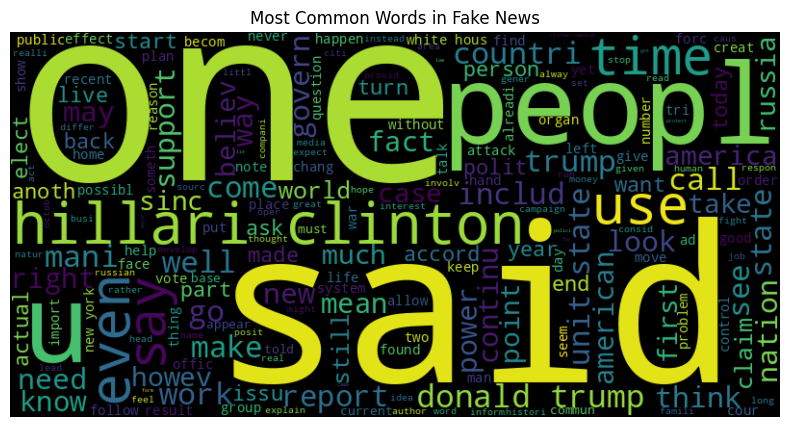

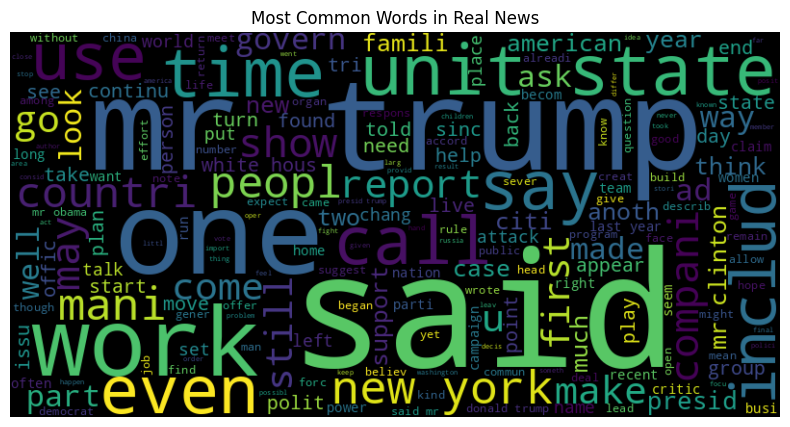

In [8]:
from wordcloud import WordCloud

# Fake News WordCloud
plt.figure(figsize=(10,5))
wc = WordCloud(width=800, height=400, background_color='black').generate(" ".join(df[df['label'] == 1]['clean_text']))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Fake News")
plt.show()

# Real News WordCloud
plt.figure(figsize=(10,5))
wc = WordCloud(width=800, height=400, background_color='black').generate(" ".join(df[df['label'] == 0]['clean_text']))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Real News")
plt.show()

# What These Findings Tell Us:
Balanced Labels -> No need to artificially balance the dataset. We can train the model as-is.

Fake News is Shorter 📉 – Fake news tends to have shorter articles, which might be an interesting feature.

Common Words Differ 🔍:

   Fake News talks a lot about Clinton, Trump, and "people."

  Real News uses "Mr.," "said," and "state" a lot, suggesting formal reporting style.

# Code to Convert Text into TF-IDF Features

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the 'clean_text' column
X = vectorizer.fit_transform(df['clean_text']).toarray()

# Target variable (labels)
y = df['label']

# Check the shape of X (features) and y (labels)
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# Save the vectorizer
import joblib
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

Feature matrix shape: (20761, 5000)
Target vector shape: (20761,)


['tfidf_vectorizer.pkl']

# Split Data into Train & Test Sets

80% for training (learning phase).

20% for testing (evaluation phase).

In [10]:
from sklearn.model_selection import train_test_split

# Splitting up the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check data shapes
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (16608, 5000)
Testing data shape: (4153, 5000)


# Training the Logistic Regression Model

In [11]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train, y_train)

print("Model training completed! 🎉")

Model training completed! 🎉


# Testing the Model & Evaluating: Performance

In [13]:
from sklearn.metrics import accuracy_score, classification_report

# Predict labels for test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

# Detailed evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 94.51%
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94      2079
           1       0.93      0.96      0.95      2074

    accuracy                           0.95      4153
   macro avg       0.95      0.95      0.95      4153
weighted avg       0.95      0.95      0.95      4153



# Code to Save the Model

In [14]:
import joblib

# Save the trained model
joblib.dump(model, "fake_news_model.pkl")
print("Model saved as fake_news_model.pkl")

Model saved as fake_news_model.pkl


 load it instead of retraining!
`model = joblib.load("fake_news_model.pkl")`
